In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, SpatialDropout1D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical  # Import to_categorical
from abbreivations import replacement_dict
# Download NLTK resources
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df=pd.read_csv('labeled_data.csv')

df.shape

(24783, 7)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB



# Removing usernames

In [5]:
# Function to remove usernames
def remove_usernames(tweet):
    return re.sub(r'@\w+', '', tweet)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(remove_usernames)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


# Removing special symbols

In [6]:
# Function to remove sequence
def remove_sequence(tweet):
    return re.sub(r'\b\d+\b', '', tweet)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(remove_sequence)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


# Removing Urls

In [7]:
# function to remove urls
def remove_urls(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', tweet, flags=re.MULTILINE)
df['tweet']= df['tweet'].apply(remove_urls)

# Removing punctuations

In [8]:
df['tweet'] = df['tweet'].str.lower()
 
# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about cl...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat ...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she st...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true ...


# Removing abbreviations

In [9]:

def replace_words(tweet, abbreviations_dict):
    # Create a regex pattern from the keys of the dictionary
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in abbreviations_dict.keys()) + r')\b')
    # Replace matched words with their corresponding values
    return pattern.sub(lambda x: abbreviations_dict[x.group()], tweet)

# Apply the function to your DataFrame
df['tweet'] = df['tweet'].apply(lambda x: replace_words(x.lower(), replacement_dict))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,retweet as euro a euro woman euro you euro s...
1,1,3,0,3,0,1,retweet boy euro that is euro coldtyga euro ...
2,2,3,0,3,0,1,retweet friend euro retweet you euro ever e...
3,3,3,0,2,1,1,retweet she euro look euro like euro a euro...
4,4,6,0,6,0,1,retweet the euro shit euro you euro hear eur...


# Lemmatization

In [10]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
        # Let's Lemmatize the word as well
        # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,retweet euro euro woman euro euro shouldnt eur...
1,1,3,0,3,0,1,retweet boy euro euro coldtyga euro euro bad e...
2,2,3,0,3,0,1,retweet friend euro retweet euro ever euro fuc...
3,3,3,0,2,1,1,retweet euro look euro like euro euro tranny
4,4,6,0,6,0,1,retweet euro shit euro euro hear euro euro eur...


In [11]:
df.to_csv('final.csv', index=False) #save as file

# Data visualization

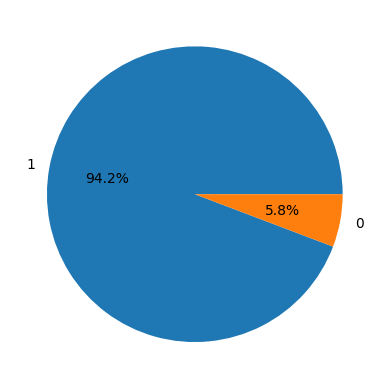

In [23]:
# class 0 - non offensive and no hate speech
# class 1 - offensive
# class 2 - hate speech
label_mapping = {0: 0, 1: 1, 2: 1}
df['class'] = df['class'].map(label_mapping)
plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


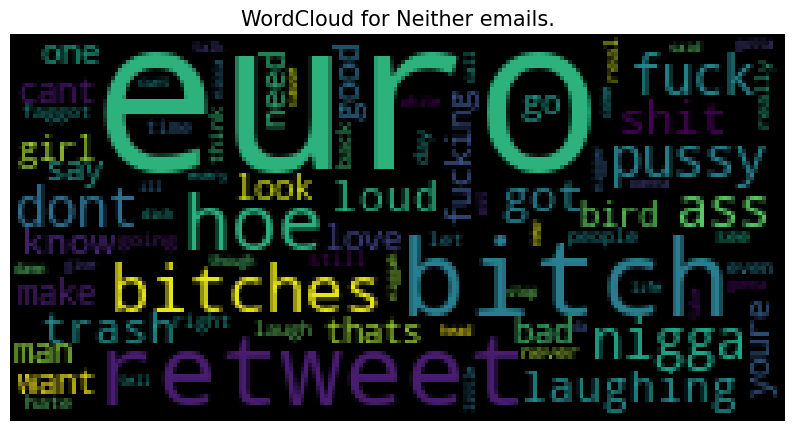

In [13]:
from wordcloud import WordCloud
def plot_word_cloud(data, typ):
# Joining all the tweets to get the corpus
    email_corpus = " ".join(df['tweet'])

    plt.figure(figsize = (10,10))

    # Forming the word cloud
    wc = WordCloud(max_words = 100,
                    width = 200,
                    height = 100,
                    collocations = False).generate(email_corpus)

    # Plotting the wordcloud obtained above
    plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
    print()

plot_word_cloud(df[df['class']==2], typ='Neither')


# Loading the dataset and tokenization

Shape of X_train_pad: (15860, 100)
Shape of y_train_cat: (15860, 2)
Shape of X_val_pad: (3966, 100)
Shape of y_val_cat: (3966, 2)
Shape of X_test_pad: (4957, 100)
Shape of y_test_cat: (4957, 2)


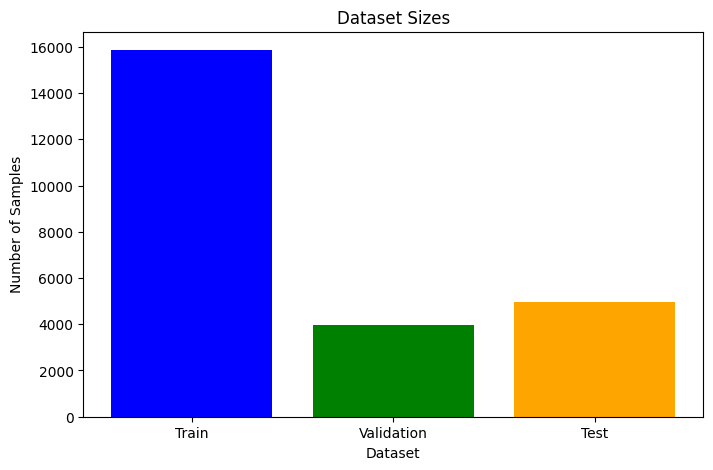

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load the dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'  # Adjust if the column name is different

# Ensure all entries in the text column are strings
df[text_column] = df[text_column].astype(str).fillna('')

# Map offensive and hate speech to 1 (hate speech), non-offensive to 0 (normal)
label_mapping = {0: 0, 1: 1, 2: 1}
df['label'] = df['class'].map(label_mapping)

# Split the data
X = df[text_column].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ensure all training, validation, and test data are strings
X_train = [str(text) for text in X_train]
X_val = [str(text) for text in X_val]
X_test = [str(text) for text in X_test]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Tokenize the text data
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Verify the shapes of the padded sequences and categorical labels
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of X_val_pad:", X_val_pad.shape)
print("Shape of y_val_cat:", y_val_cat.shape)
print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of y_test_cat:", y_test_cat.shape)

# Plotting bar graph for dataset sizes
datasets = ['Train', 'Validation', 'Test']
sizes = [len(X_train), len(X_val), len(X_test)]

plt.figure(figsize=(8, 5))
plt.bar(datasets, sizes, color=['blue', 'green', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Sizes')
plt.show()


# Model building and plotting


Epoch 1/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.9357 - loss: 0.8702 - val_accuracy: 0.9415 - val_loss: 0.2170
Epoch 2/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.9406 - loss: 0.2103 - val_accuracy: 0.9397 - val_loss: 0.1961
Epoch 3/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.9474 - loss: 0.1700 - val_accuracy: 0.9399 - val_loss: 0.1906
Epoch 4/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.9460 - loss: 0.1624 - val_accuracy: 0.9407 - val_loss: 0.1912
Epoch 5/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.9518 - loss: 0.1470 - val_accuracy: 0.9342 - val_loss: 0.2012
Epoch 6/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.9548 - loss: 0.1306 - val_accuracy: 0.9395 - val_loss: 0.2043
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Weighted F1 Score: 0.922467472790126
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.11      0.18       290
        

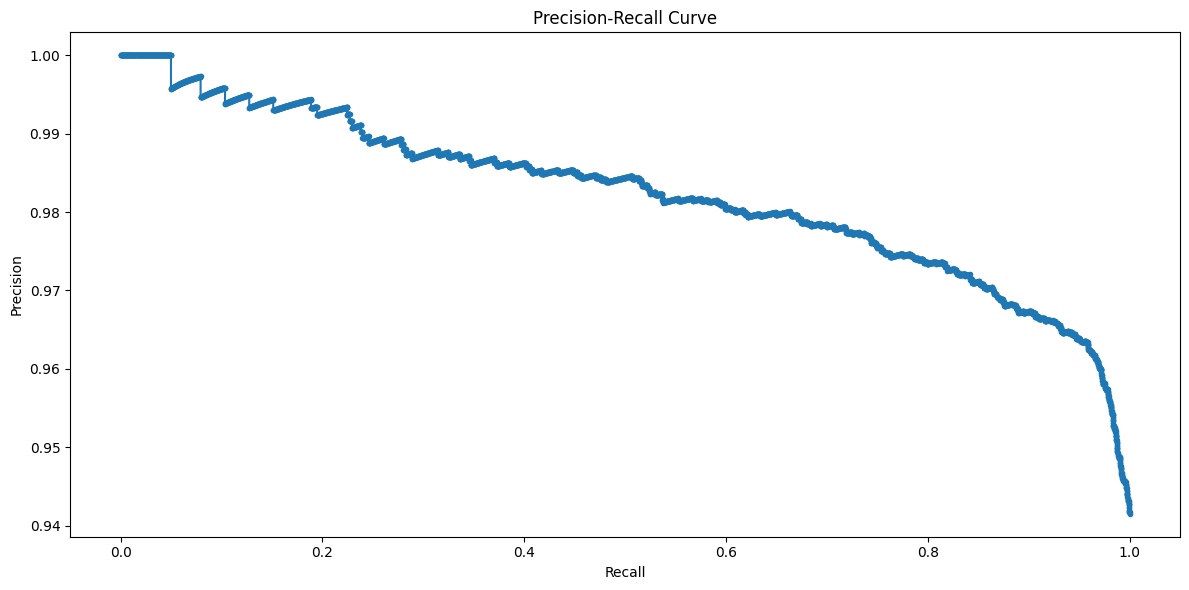

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,254,216 (12.41 MB)

 Trainable params: 1,084,738 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,169,478 (8.28 MB)

In [19]:
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assume X_train_pad, X_test_pad, y_train_cat, y_test_cat, max_words, max_len are defined

# Model definition
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(SpatialDropout1D(0.3))  # Increased dropout rate
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))))  # Added L2 regularization
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Implement EarlyStopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat),
                    epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_pred_cat = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_cat, axis=1)

# Calculate F1 score
f1score = f1_score(np.argmax(y_test_cat, axis=1), y_pred, average='weighted')
print("Weighted F1 Score:", f1score)

# Print classification report
print("Classification Report:\n", classification_report(np.argmax(y_test_cat, axis=1), y_pred))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot precision and recall
precision, recall, _ = precision_recall_curve(np.argmax(y_test_cat, axis=1), y_pred_cat[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Print model summary
model.summary()


# Predictions

In [20]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the trained model
model.save('trained_model.h5')
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import load_model

# Load the uncleaned new dataset
new_df = pd.read_csv('labeled_data.csv')  # Replace with the path to your new dataset
text_column = 'tweet'  # Adjust if the column name is different

# Ensure all entries in the text column are strings
new_df[text_column] = new_df[text_column].astype(str).fillna('')

# Load the previously saved tokenizer
import pickle
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Tokenize the new dataset
new_seq = tokenizer.texts_to_sequences(new_df[text_column])

# Pad the sequences to the same length as the training data
max_len = 100  # Ensure this is the same max_len used during training
new_pad = pad_sequences(new_seq, maxlen=max_len)

# Load the trained model
model = load_model('trained_model.h5')  # Ensure this is the path to your saved model

# Make predictions
predictions = model.predict(new_pad)
predicted_labels = np.argmax(predictions, axis=1)

# Add the predictions to the new_df dataframe
new_df['predicted_label'] = predicted_labels

# Optionally map the numerical labels back to original classes
label_mapping = {0: 'hate_speech', 1: 'non_hate_speech'}  # Adjust if different
new_df['predicted_label_name'] = new_df['predicted_label'].map(label_mapping)

# Save the results to a new CSV file
new_df.to_csv('predictions.csv', index=False)

# Print the first few rows of the dataframe with predictions
print(new_df.head())


775/775 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  predicted_label  \
0  !!! RT @mayasolovely: As a woman you shouldn't...                1   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...                1   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...                1   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...                1   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...                1   

  predicted_label_name  
0      non_hate_speech  
1      non_hate_speech  
2   